# Credit to Shreya Kapoor, https://github.com/ShreyaKapoor18/BCI_Neurotech

In [209]:

#%%
import mne
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
#from mne_bids import BIDSPath, read_raw_bids/
from scipy.io import loadmat
import mne
from mne.viz import plot_alignment, snapshot_brain_montage
from mne.time_frequency import fit_iir_model_raw
import gc
from scipy import signal
gc.enable()

col_names = [f'CH_{i}' for i in range(1, 61)]
col_names.extend(['paradigm_info'])
print(len(col_names))
sampling_freq = 1200
ch_types =['misc'] + ['ecog'] * 60 + ['stim']

info = mne.create_info(ch_names=["time"] + col_names, ch_types=ch_types, sfreq=sampling_freq)
# Load the data
data = loadmat("ECoG_Handpose.mat")['y']
# Index 1-60 means channels 2-61
raw = mne.io.RawArray(data[0:62,:], info) # we dont need the first channel
gc.collect()

raw.load_data().resample(sampling_freq )  #nyquist theorem
events = mne.find_events(raw, stim_channel="paradigm_info")
print(events)
raw.pick_types(ecog=True)
#%%
event_id = dict( fist_movement = 1 , peace_movement = 2 , open_hand = 3 )



61
Creating RawArray with float64 data, n_channels=62, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
90 events found
Event IDs: [1 2 3]
[[ 14496      0      3]
 [ 20256      0      1]
 [ 26112      0      3]
 [ 31680      0      2]
 [ 37440      0      2]
 [ 43056      0      3]
 [ 48000      0      3]
 [ 53760      0      2]
 [ 58896      0      3]
 [ 64320      0      1]
 [ 69792      0      2]
 [ 75264      0      2]
 [ 81120      0      2]
 [ 86256      0      3]
 [ 91200      0      2]
 [ 97056      0      2]
 [102768      0      1]
 [108192      0      2]
 [113568      0      3]
 [118608      0      1]
 [123888      0      2]
 [128928      0      3]
 [134640      0      3]
 [139632      0      3]
 [144768      0      1]
 [150336      0      2]
 [155568      0      1]
 [161232      0      1]
 [167040      0      2]
 [172368      0      3]
 [177408      0      2]
 [183216      0  

In [210]:
timings = data[0,:]
delta_t = timings[1] - timings[0]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3961 samples (3.301 sec)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.50
- Lower transiti

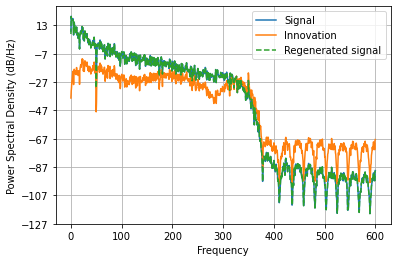

In [211]:

#%%
'''
After excluding channels that were notably bad due to
high impedance, we re-referenced the data by the common
average. After that, a notch-filter cascade (recursive 6th-order
Butterworth, bandwidth: 5 Hz) up to the 6th harmonic was
used to remove interference peaks from the spectrum at integer
multiples of the power line frequency'''

# They set the trial length to 0.75 seconds pre- and post-onset, respectively
# full_mean = raw._data.mean(axis=0)
#mean_col =# get the meaning of the column
# raw._data -= full_mean # this could cause bias though
raw.filter(1, 300)
# raw.filter(1, None)
raw.set_eeg_reference("average")
nf = 50
raw.notch_filter([nf], notch_widths=2, trans_bandwidth=1)  # raw.notch_filter([60], trans_bandwidth=5)


#picks = mne.pick_types(raw.info, meg='grad', exclude='bads')

order = 5  # define model order
#picks = picks[:1]

# from https://mne.tools/stable/auto_examples//time_frequency/temporal_whitening.html#sphx-glr-auto-examples-time-frequency-temporal-whitening-py
# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw, order=order, picks=["ecog"], tmin=timings[0], tmax=timings[-1])
d, times = raw[0, 10000:20000]  # look at one channel from now on
d = d.ravel()  # make flat vector
innovation = signal.convolve(d, a, "valid")
d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length

# plt.close('all')
# plt.figure()
# plt.plot(d[:100], label='signal')
# plt.plot(d_[:100], label='regenerated signal')
# plt.legend()

plt.figure()
plt.psd(d, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(innovation, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(d_, Fs=raw.info['sfreq'], NFFT=2048, linestyle='--')
plt.legend(('Signal', 'Innovation', 'Regenerated signal'))
plt.show()
#%%
#raw.plot()
#plt.savefig('results/mne_plot.png')
#picks=['CH_5', 'CH_10', 'CH_15']

#raw.plot_psd(average=True)
#plt.savefig('results/plot_spectral_density.png')

#plt.savefig('results/ecog.png')
#raw.plot_sensors(ch_type='ecog')

# Then we remove line frequency interference



In [218]:
raw.filter?

In [212]:
m = raw._data
m.mean(), m.std(), m.shape

(-8.419765703696779e-15, 831.8760136558976, (60, 507025))

Effective window size : 1.707 (s)


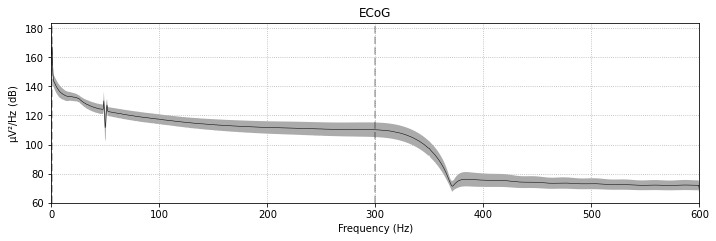

0

In [213]:
raw.plot_psd(average=True)
0

In [214]:
# raw._data /= raw._data.max()

In [376]:
import mne.decoding


# for n_components in range(1, 30):
# lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
# clf = sklearn.pipeline.Pipeline([('CSP', csp), ('LDA', lda)])
# scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
# print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
#                                                           class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit(epochs.get_data(), epochs.events[:, -1])

# csp.plot_patterns(epochs.info, ch_type='ecog', units='Patterns (AU)', size=1.5)
# plt.show()

Loading data for 90 events and 1801 original time points ...
Computing rank from data with rank=None
    Using tolerance 4.1e+02 (2.2e-16 eps * 60 dim * 3.1e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+02 (2.2e-16 eps * 60 dim * 3.2e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e+02 (2.2e-16 eps * 60 dim * 2.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 60 data channels with 0 projectors
    Setting small MAG eig

CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=True, n_components=4, norm_trace=False, rank=None, reg=None,
  transform_into='average_power')

In [457]:
# To be used
csp_cache = {}
model_cache = {}

In [473]:
group_cache = {"csp": csp_cache}

In [489]:
predictor_cache = {}

In [459]:
from tqdm.auto import tqdm, trange
import random


random.seed(16)
data = epochs.get_data()
n_splits = 16
n_folds = 3
fold_size = len(data) // n_folds
folds = []
for s in trange(n_splits):
    fold = []
    ts = list(range(len(data)))
    random.shuffle(ts)
    for i in range(0, len(data), fold_size):
        x = data[ts][i:i+fold_size]
        y = epochs.events[ts][i:i+fold_size, -1]
        fold.append((x, y))
    folds.append(fold)

Loading data for 90 events and 1801 original time points ...


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 26.4583±2.6707
percentage_accuracy_score: 26.4583


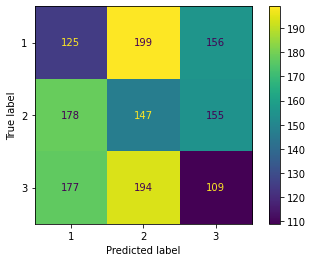





Pipeline(steps=[('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                                                 low=160)))])),
    

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 81.5972±2.7208
percentage_accuracy_score: 81.5972


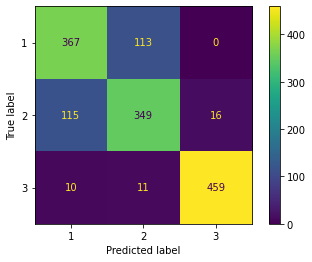





Pipeline(steps=[('prep',
                 FeatureUnion(transformer_list=[('40hz',
                                                 CachedPredictor(model=BandPower(high=100,
                                                                                 low=40))),
                                                ('80hz',
                                                 CachedPredictor(model=BandPower(high=140,
                                                                                 low=80))),
                                                ('120hz',
                                                 CachedPredictor(model=BandPower(high=180,
                                                                                 low=120))),
                                                ('160hz',
                                                 CachedPredictor(model=BandPower(high=220,
                                                                                 low=160)))])),
    

  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 74.4444±4.1201
percentage_accuracy_score: 74.4444


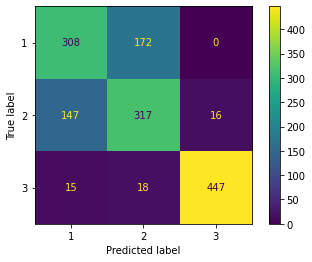





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a553a0>)),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 71.5972±5.3427
percentage_accuracy_score: 71.5972


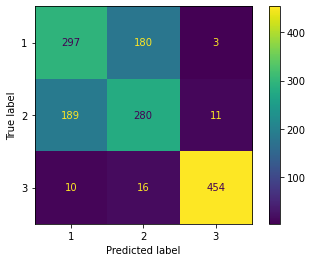





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 4},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a553a0>)),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 67.7778±5.5277
percentage_accuracy_score: 67.7778


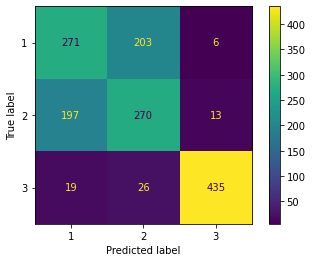





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a55e50>)),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 87.7083±4.2030
percentage_accuracy_score: 87.7083


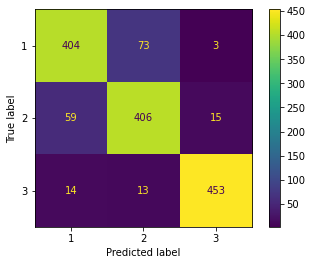





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 12},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a55e50>)),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 84.1667±5.3069
percentage_accuracy_score: 84.1667


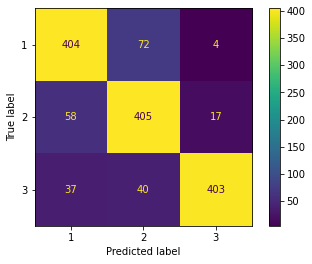





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a55040>)),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 82.6389±5.7450
percentage_accuracy_score: 82.6389


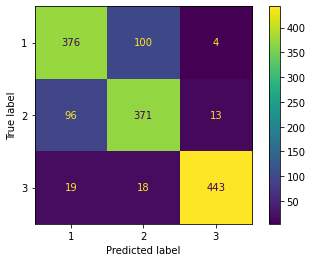





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 20},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a55040>)),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.6389±6.3328
percentage_accuracy_score: 77.6389


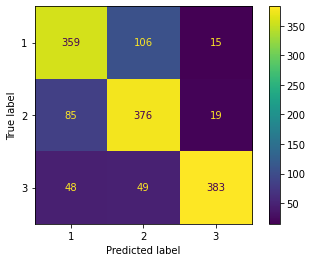





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a55670>)),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.6389±3.6825
percentage_accuracy_score: 77.6389


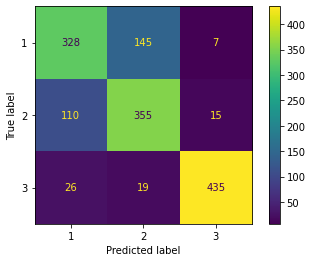





Pipeline(steps=[('prep',
                 CachedTrainer(group='csp', kwargs={'n_components': 28},
                               model_lambda=<function <listcomp>.<lambda> at 0x7f3885a55670>)),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 75.0000±4.2310
percentage_accuracy_score: 75.0000


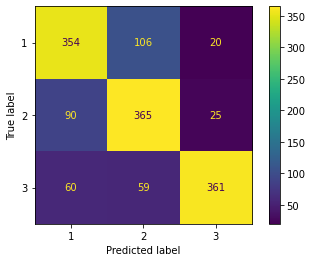





Pipeline(steps=[('prep', CachedPredictor(model=PSDWelch(high=300, low=40))),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 65.9722±4.1921
percentage_accuracy_score: 65.9722


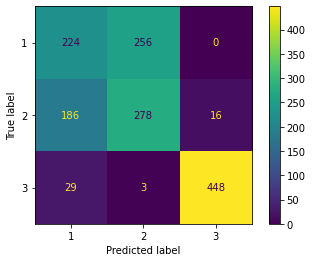





Pipeline(steps=[('prep', CachedPredictor(model=PSDWelch(high=300, low=40))),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.3611±3.9062
percentage_accuracy_score: 77.3611


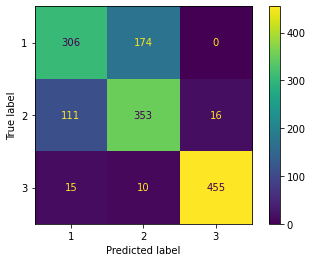





Pipeline(steps=[('prep',
                 CachedPredictor(model=PSDWelch(high=300, low=40, n_fft=512))),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 51.8056±3.3072
percentage_accuracy_score: 51.8056


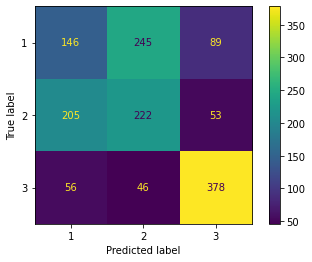





Pipeline(steps=[('prep',
                 CachedPredictor(model=PSDWelch(high=300, low=40, n_fft=512))),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 54.7917±3.2565
percentage_accuracy_score: 54.7917


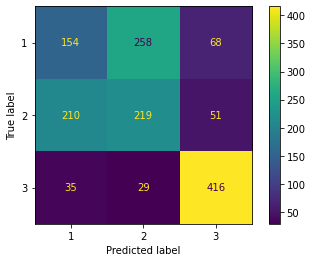





Pipeline(steps=[('prep', CachedPredictor(model=PSDWelch(high=250, low=100))),
                ('scaler', StandardScaler()),
                ('model', LinearDiscriminantAnalysis())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 67.0833±4.8730
percentage_accuracy_score: 67.0833


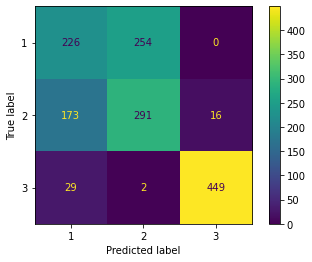





Pipeline(steps=[('prep', CachedPredictor(model=PSDWelch(high=250, low=100))),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])


  0%|          | 0/48 [00:00<?, ?it/s]

accuracy: 77.1528±3.3557
percentage_accuracy_score: 77.1528


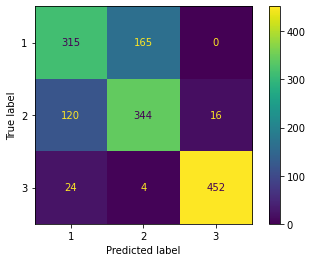

['model_cache.pkl']

In [491]:
import sklearn.discriminant_analysis
import sklearn.linear_model
import sklearn.pipeline
import sklearn.dummy
import scipy.signal
import pandas as pd
import contextlib
import io


def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def hash_xy(x, y):
    return hash((str(x), str(y)))

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x


def uni_concat(xs):
    if not xs:
        return
    if isinstance(xs[0], list):
        return sum(xs, [])
    else:
        try:
            return pd.concat(xs)
        except TypeError:
            return np.concatenate(xs)


def cross_fold(models, folds, metrics=[], multi_level=False):
    if not multi_level and len(folds[0]) == 2:  # Single-level (one cross-fold)
        folds = [folds]
    models = wrap_list(models)
    metrics = wrap_list(metrics) + [percentage_accuracy_score]
    scores = []
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        acc_samples = []
        avg_accs = []
        bar = tqdm(total=sum(map(len, folds)))
        for fold in folds:
            true_ = []
            test_accs_ = []
            for i, (x_test, y_test) in enumerate(fold):
                model_hash = hash((str(model), hash_xy(x_test, y_test)))
                if model_hash in model_cache:
                    y__test = model_cache[model_hash]
                else:
                    model_ = sklearn.base.clone(model)
                    x_train, y_train = map(uni_concat, zip(*(fold[:i] + fold[i+1:])))
                    try:
                        model_.fit(x_train, y_train)
                    except np.linalg.LinAlgError:
                        y__test = None
                    else:
                        y__test = model_.predict(x_test)
                    model_cache[model_hash] = y__test
                if y__test is None:
                    bar.update(1)
                    continue
                predicted.append(y__test)
                true_.append(y_test), true.append(y_test)
                test_acc = percentage_accuracy_score(y_test, y__test)
                test_accs_.append(test_acc), test_accs.append(test_acc)
                bar.update(1)
                bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                    f"sample accuracy: {sum(test_accs_) / len(test_accs_):.4f}, "
                                    f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
            acc_samples.append(sum(test_accs_) / len(test_accs_))
        
        print(f"accuracy: {np.mean(acc_samples):.4f}±{np.std(acc_samples):.4f}")
        bar.close()
        true, predicted = uni_concat(true), uni_concat(predicted)
        for metric in metrics:
            # Accuracy decomposes cleanly, but other metrics might not
            score = metric(true, predicted)
            print(f"{metric.__name__}: {score:.4f}")
        # Final metric determines the result
        scores.append(score)  
        
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()


class CachedTrainer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model_lambda, group, kwargs=None):
        self.model_lambda = model_lambda
        self.group, self.kwargs = group, kwargs if kwargs is not None else {}
    
    def fit(self, x, y):
        if not hasattr(self, "model"):
            # stateful
            h = hash_xy(x, y)
            if self.group not in group_cache:
                group_cache[self.group] = {}
            if h not in group_cache[self.group]:
                with contextlib.redirect_stdout(io.StringIO()):
                    c = self.model_lambda().fit(x, y)
                group_cache[self.group][h] = c
            self.model = sklearn.base.copy.copy(csp_cache[h])
            for k, v in self.kwargs.items():
                setattr(self.model, k, v)  # hack for CSP models
        return self
    
    def transform(self, *args, **kwargs):
        assert hasattr(self, "model")
        return self.model.transform(*args, **kwargs)


class CachedPredictor(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, model):
        self.model = model
        self.model_str = str(self.model)
    
    def fit(self, x, y):
        self.model.fit(x, y)
        return self
    
    def transform(self, x):
        predictor_hash = hash((self.model_str, str(x)))
        if predictor_hash not in predictor_cache:
            predictor_cache[predictor_hash] = self.model.transform(x)
        return predictor_cache[predictor_hash]

    
def butter_bandpass(lowcut, highcut, fs, order=5):
    return scipy.signal.butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y


class Combiner(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high):
        self.low, self.high = low, high
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        filtered = butter_bandpass_filter(x, self.low, self.high, sampling_freq)
        return np.log(np.mean(filtered ** 2, axis=-1))


class BandPower(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high):
        self.low, self.high = low, high
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        filtered = butter_bandpass_filter(x, self.low, self.high, sampling_freq)
        return np.log(np.mean(filtered ** 2, axis=-1))


class PSDWelch(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, low, high, n_fft=256):
        self.low, self.high, self.n_fft = low, high, n_fft
    
    def fit(self, x, y):
        return self  # no training required!
    
    def transform(self, x):
        with contextlib.redirect_stdout(io.StringIO()):
            bp, freqs = mne.time_frequency.psd_array_welch(x, sampling_freq,
                                                      fmin=self.low, fmax=self.high,
                                                      n_fft=int(self.n_fft), average="mean")
        return bp.reshape((bp.shape[0], -1))

band_features = [sklearn.pipeline.FeatureUnion([("40hz", CachedPredictor(BandPower(40, 100))),
                                    ("80hz", CachedPredictor(BandPower(80, 140))),
                                    ("120hz", CachedPredictor(BandPower(120, 180))),
                                    ("160hz", CachedPredictor(BandPower(160, 220)))])]
csp_features = [CachedTrainer(
        lambda: mne.decoding.CSP(reg=None, log=True, norm_trace=False), "csp", dict(n_components=c))
                 for c in range(4, 16*2, 8)]
welch_features = [
        CachedPredictor(PSDWelch(40, 300, 256)),
        CachedPredictor(PSDWelch(40, 300, 512)),
        CachedPredictor(PSDWelch(100, 250, 256))]

models = [sklearn.dummy.DummyClassifier()] + [
    sklearn.pipeline.Pipeline([
    ("prep", prep),  # mne.decoding.CSP(n_components=16+8, reg=None, log=True, norm_trace=False, verbose=False)),
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("model", model)])
    for prep in  band_features + csp_features + welch_features
    for model in [
        sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
        sklearn.linear_model.LogisticRegression()]
]
cross_fold(models, folds)
import joblib
joblib.dump(predictor_cache, "predictor_cache.pkl")
joblib.dump(group_cache, "group_cache.pkl")
joblib.dump(model_cache, "model_cache.pkl")
0

In [ ]:
# random_folds = [df.iloc[i[0]] for i in sklearn.model_selection.KFold(n_splits=8).split(df)]
# cross_fold(models, random_foldsm_folds)

  0%|          | 0/60 [00:00<?, ?it/s]

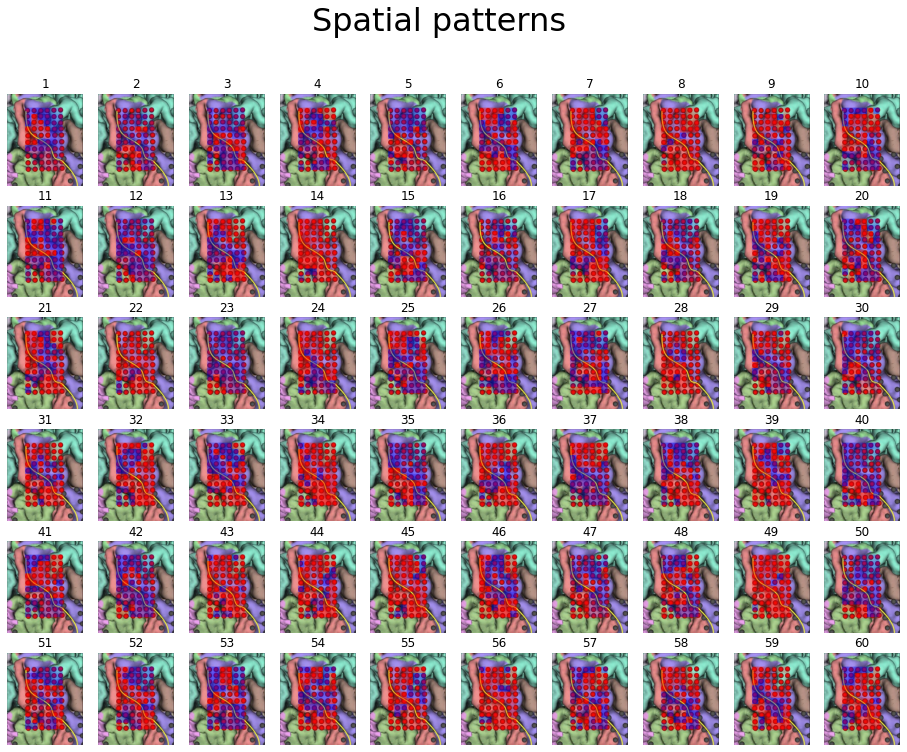

In [388]:
import matplotlib.image as mpimg
from tqdm.auto import tqdm


def plot_patterns(patterns,
                  w=10, h=6,
                  pos=np.array([1., 0., 0.]), neg=np.array([0., 0., 1.]),
                  mul=1.6*1.05, xmul=16, ymul=16,
                  xo=75, yo=57, opacity=0.5,
                  title="Spatial patterns", file_name=None,
                  overlay="brain.png",  # overlay=None,
):
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(title, fontsize=32)
    xmul, ymul = int(xmul * mul), int(ymul * mul)
    for i, f in enumerate(tqdm(patterns[:h*w])):
        ax = plt.subplot(h, w, i+1)
        ax.axis("off")
        ax.set_title(f"{i + 1}")
        pat = f.reshape((6, 10)).T.copy()
        if overlay is None:
            ax.imshow(pat)
        else:
            im = mpimg.imread(overlay)
            pat -= pat.min()
            pat /= pat.max()
            for y in range(pat.shape[0]):
                for x, e in enumerate(pat[y]):
                    patch = im[y*ymul+yo:(y)*ymul+int(ymul*1.0)+yo, x*xmul+xo:(x+1)*xmul+xo, :3]
                    k = abs(e - 0.5) * 2 * (1 - opacity) + opacity
                    patch[:, :, :] = patch * k + (neg + (pos - neg) * e) * (1 - k)
            ax.imshow(im)
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

plot_patterns(csp.patterns_, file_name="spatial_patterns_on_brain.png")

In [237]:
csp.
for i in range(1, 61):
    plt.subplot(10, 6, )

    csp.patterns_.shape)

(60, 60)


In [219]:
from tqdm.auto import trange


for n_filters in trange(1, 10):
    for start_freq in trange(1,)
    raw.copy().filter()

<RawArray | 60 x 507025 (422.5 s), ~232.2 MB, data loaded>

In [215]:



#%%
# %%

epochs = mne.Epochs(raw, events, tmin=-0.75, tmax=0.75, baseline=(None, 0))
print(epochs)

Not setting metadata
Not setting metadata
90 matching events found
Setting baseline interval to [-0.75, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  90 events (good & bad), -0.75 - 0.75 sec, baseline -0.75 – 0 sec, ~60 kB, data not loaded,
 '1': 30
 '2': 30
 '3': 30>


Epoch 1
Average


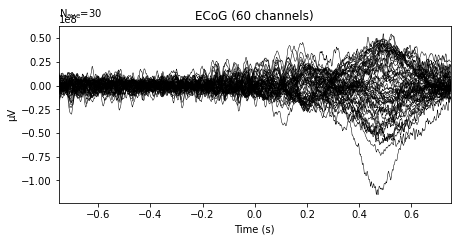

Standard Error


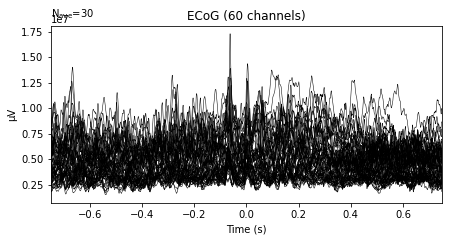

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


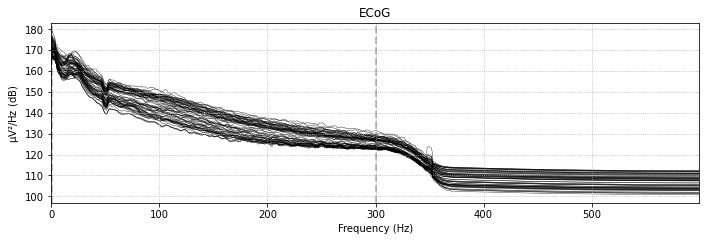

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


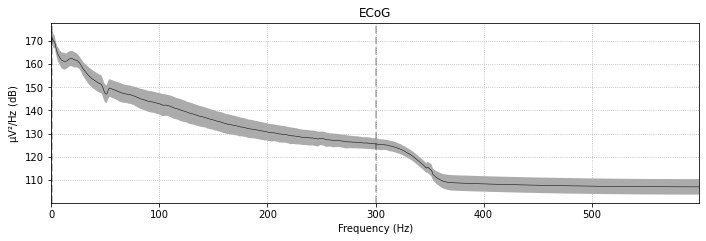

Epoch 2
Average


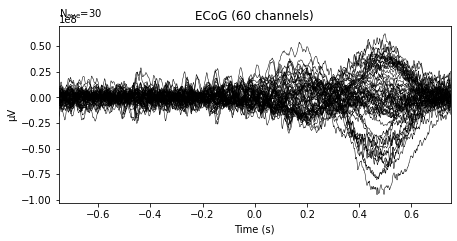

Standard Error


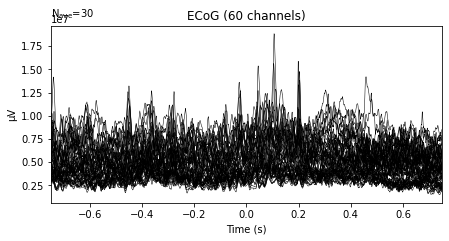

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


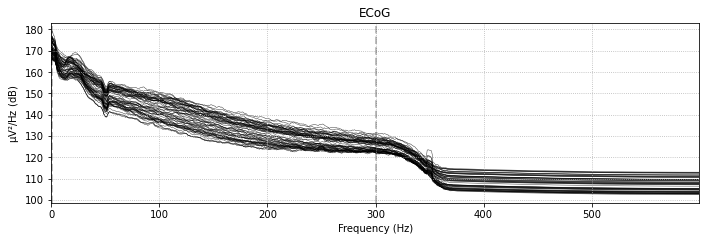

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


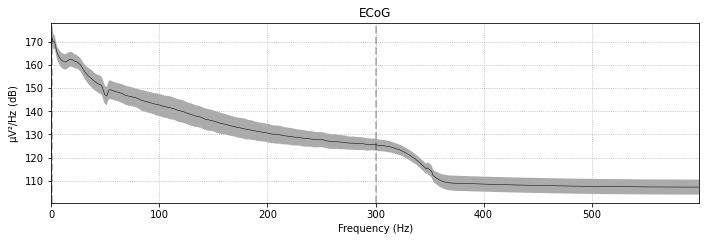

Epoch 3
Average


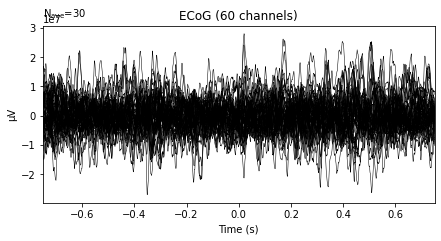

Standard Error


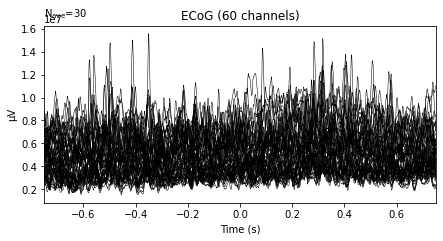

PSD
Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-216-73c6ab1dd755>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[i].plot_psd()


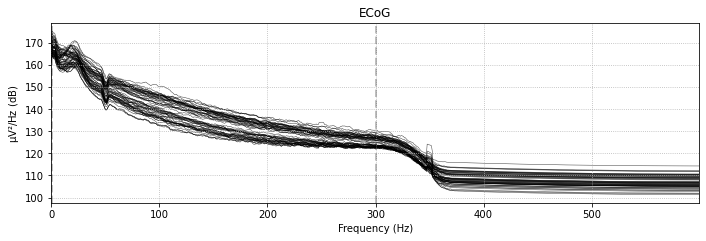

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


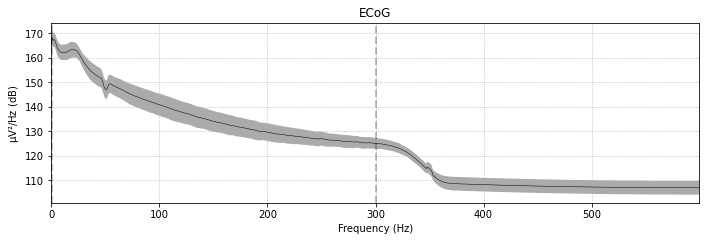

In [216]:
for i in '123':
    print("Epoch", i)
    print("Average")
    evoked = epochs[i].average()
    evoked.plot()
    print("Standard Error")
    epochs[i].standard_error().plot()
    print("PSD")
    epochs[i].plot_psd()
    epochs[i].plot_psd(average=True)

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


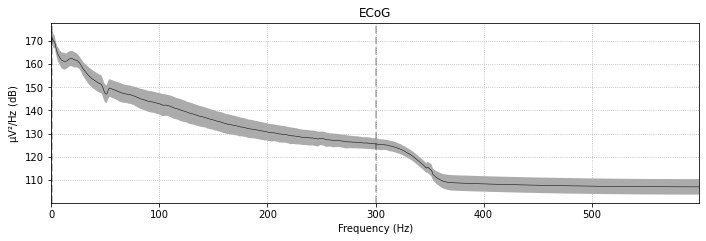

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


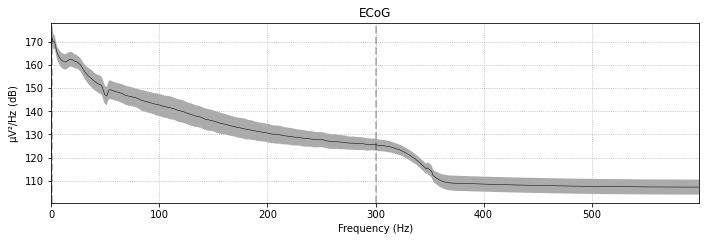

Loading data for 30 events and 1801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


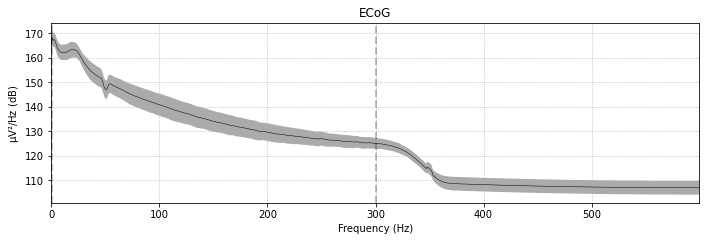

In [217]:
for i in "123":
    epochs[i].plot_psd(average=True)

In [79]:
ev = epochs["3"]
ev
ev.verbose = True

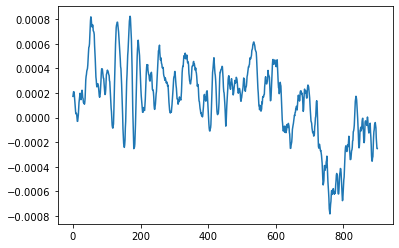

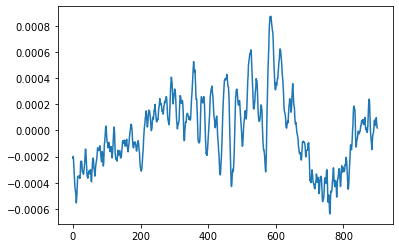

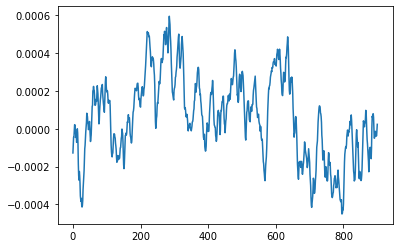

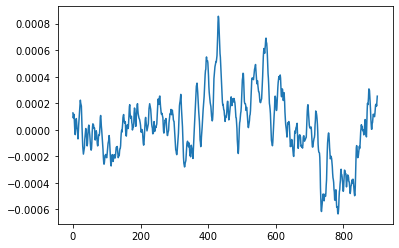

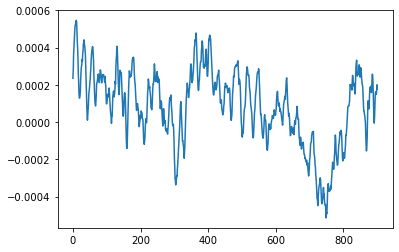

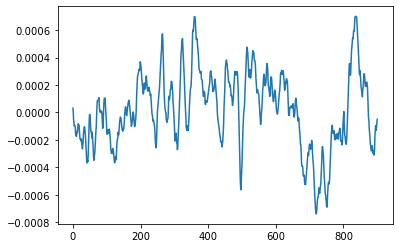

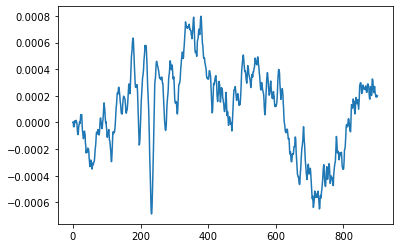

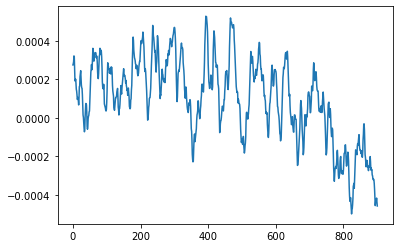

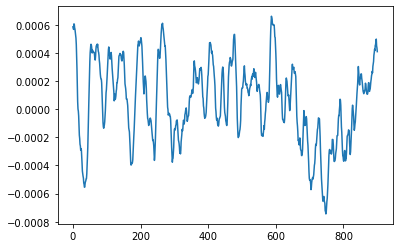

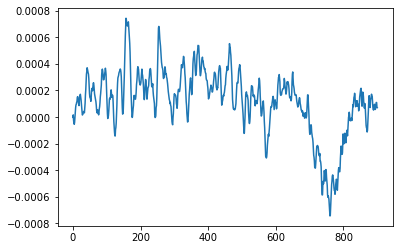

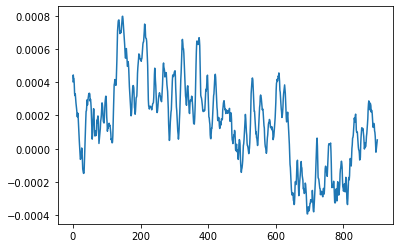

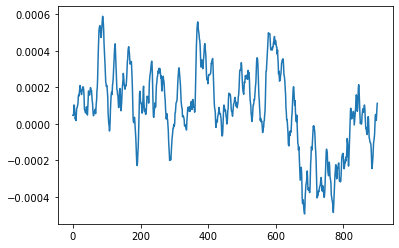

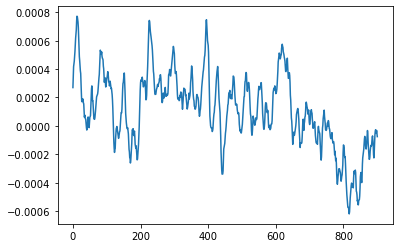

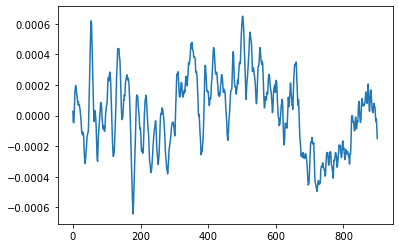

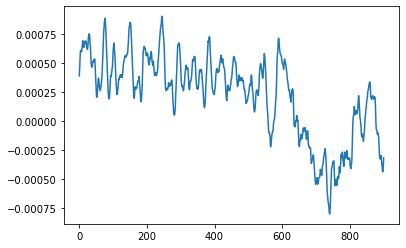

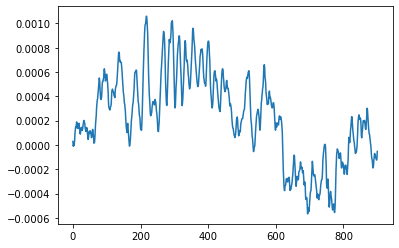

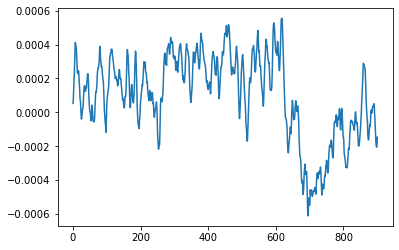

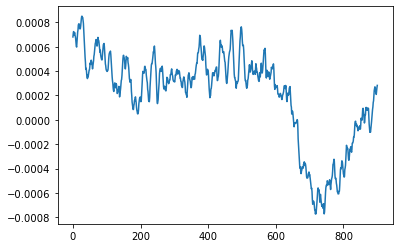

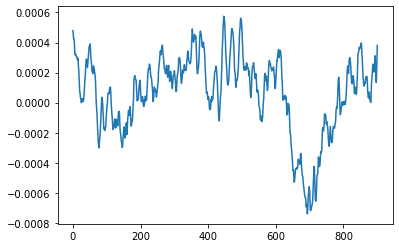

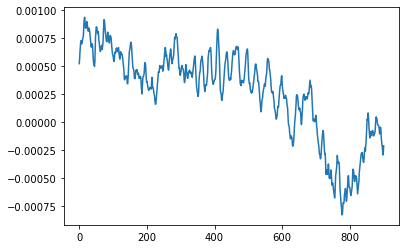

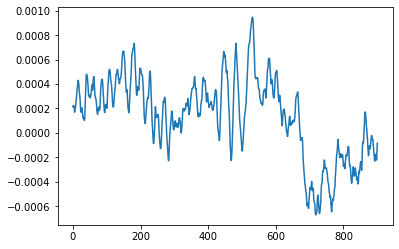

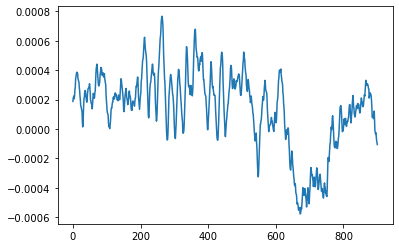

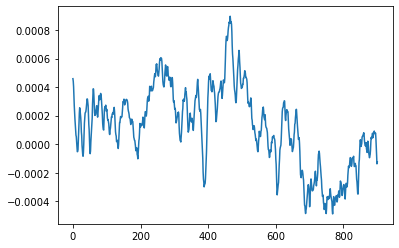

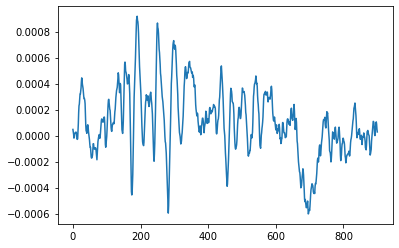

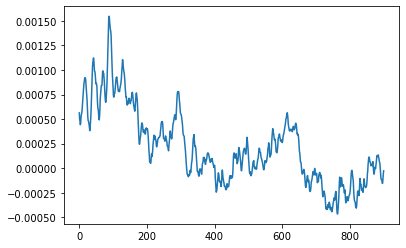

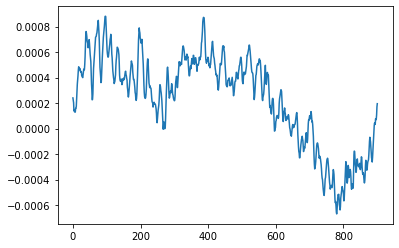

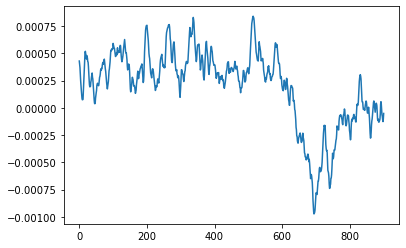

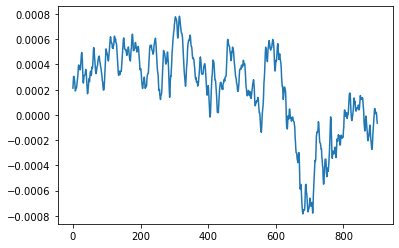

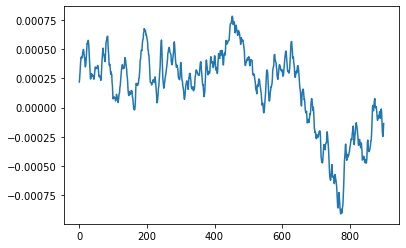

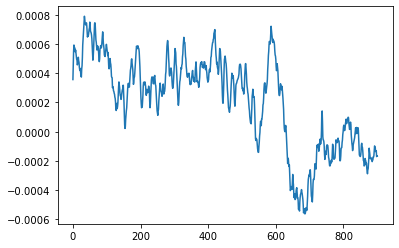

In [87]:
for event in epochs["3"]:
    plt.plot(event.mean(axis=0))
    plt.show()

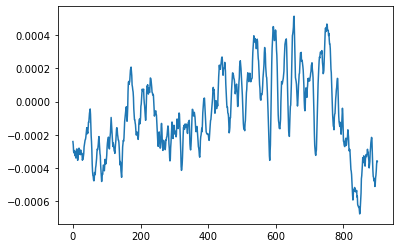

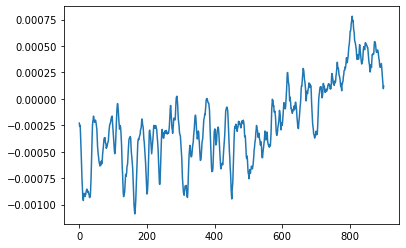

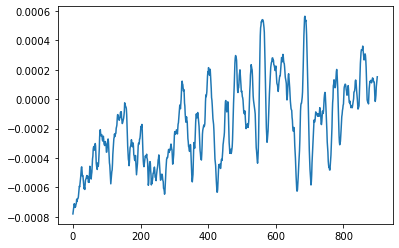

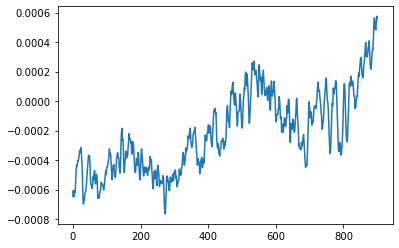

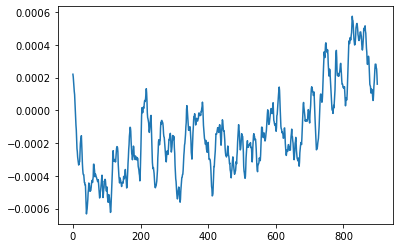

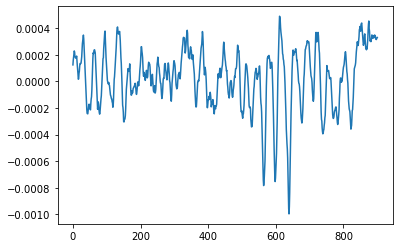

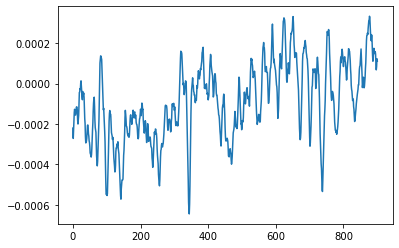

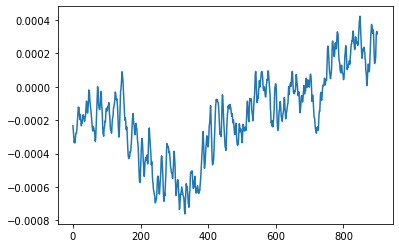

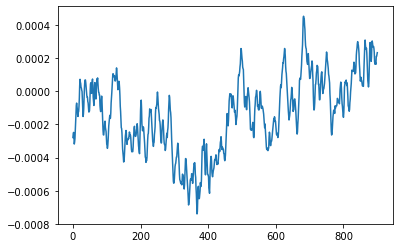

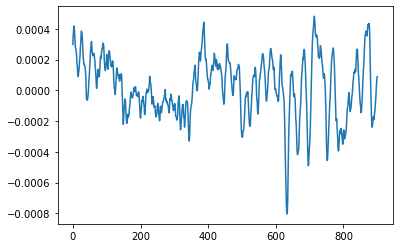

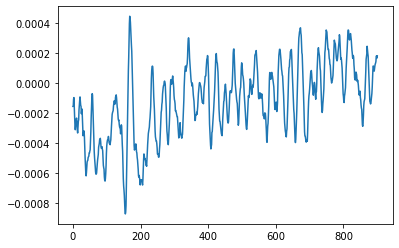

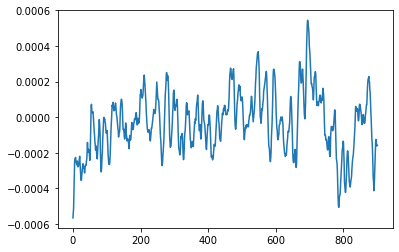

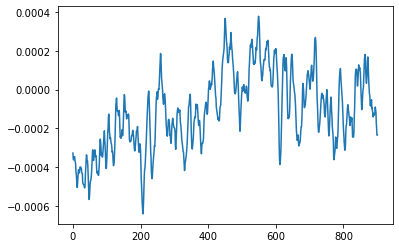

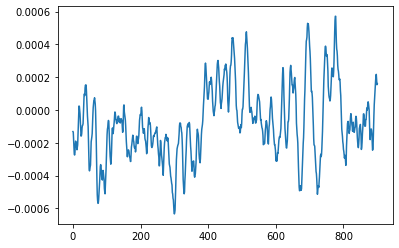

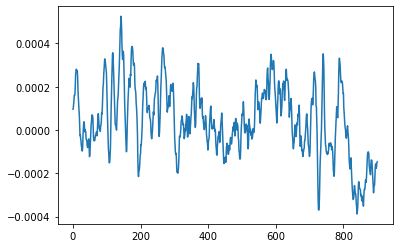

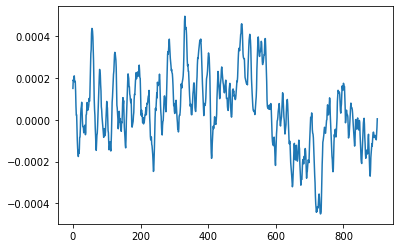

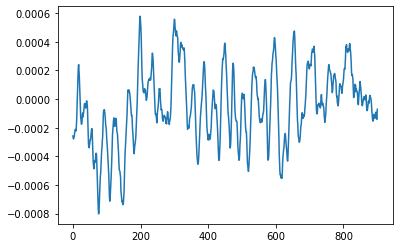

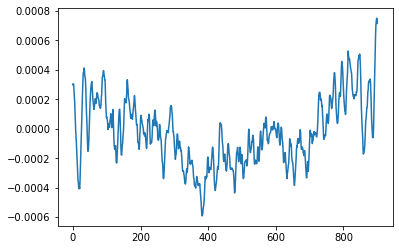

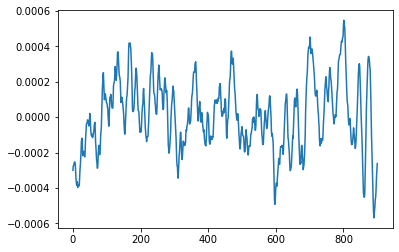

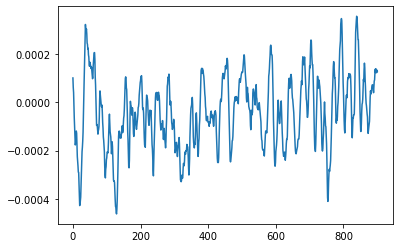

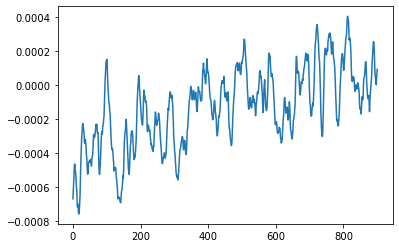

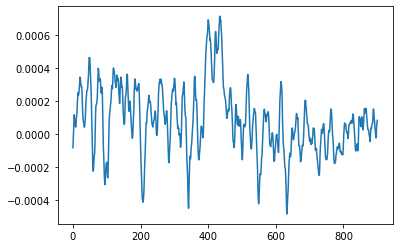

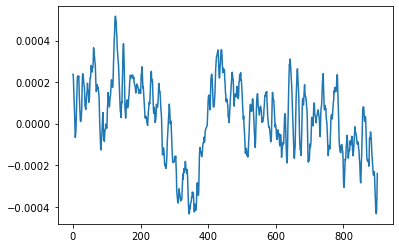

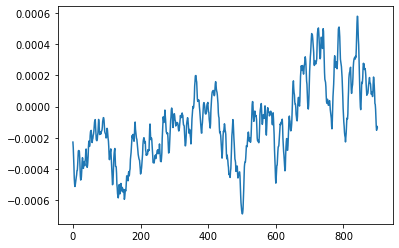

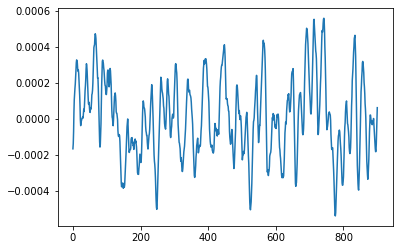

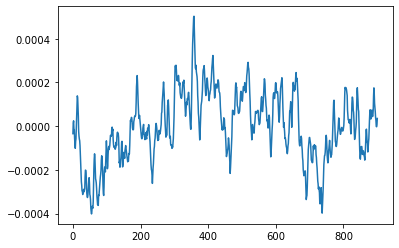

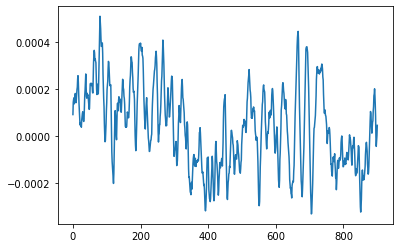

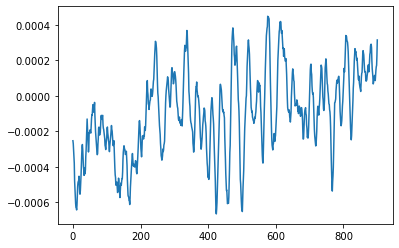

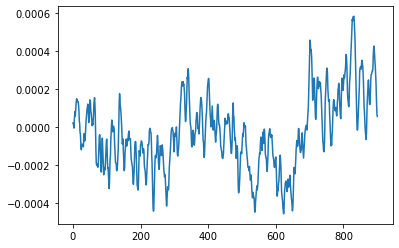

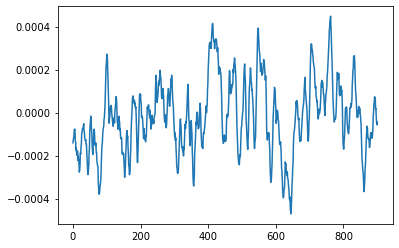

In [88]:
for event in epochs['3']:
    plt.plot(event.mean(axis=0))
    plt.show()

Loading data for 90 events and 1801 original time points ...
0 bad epochs dropped
Loading data for 90 events and 1801 original time points ...
Loading data for 20 events and 1801 original time points ...


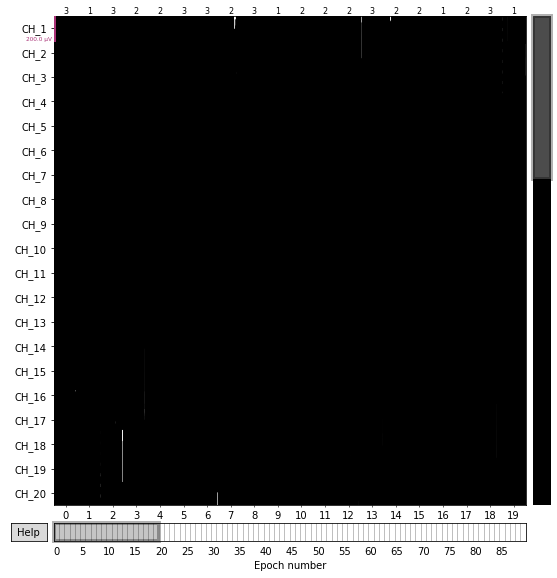

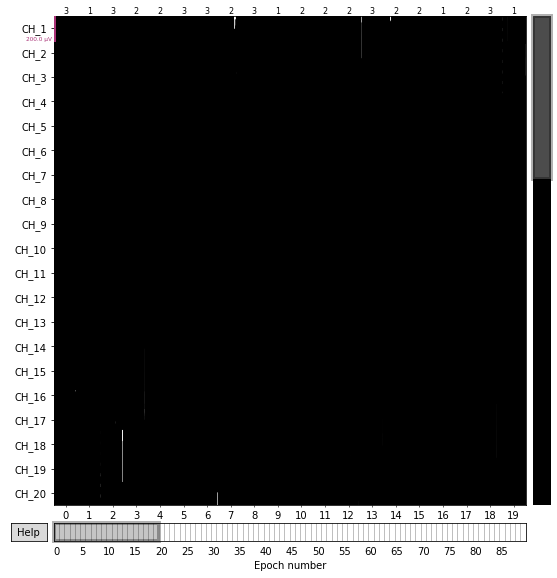

In [61]:
epochs.plot(events=events)

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat


data = loadmat("ECoG_Handpose.mat")

In [2]:
print(data)
y = data["y"]
y.shape

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jun 23 10:38:21 2020', '__version__': '1.0', '__globals__': [], 'y': array([[ 0.00000000e+00,  8.33333333e-04,  1.66666667e-03, ...,
         4.22518333e+02,  4.22519167e+02,  4.22520000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.06701961e+05, -1.06699477e+05, -1.06697859e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.62051094e+04, -8.62023672e+04, -8.61986562e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.53902262e-01,  1.53902262e-01,  1.53902262e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61574081e-01,  1.61574081e-01,  1.61574081e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.34732822e-01,  2.34732822e-01,  2.34732822e-01]])}


(67, 507025)

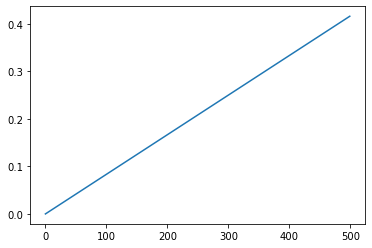

In [3]:
from matplotlib import pyplot as plt


plt.plot(y[0][:500])

In [4]:
df = pd.DataFrame(y.T, columns=["time"] + [f"CH_{i + 1}" for i in range(60)] +
             ['paradigm_info', 'data_glove_thumb', 'data_glove_index', 'data_glove_middle', 'data_glove_ring', 'data_glove_little'])
df

time           CH_1          CH_2          CH_3           CH_4  \
0         0.000000       0.000000      0.000000      0.000000       0.000000   
1         0.000833       0.000000      0.000000      0.000000       0.000000   
2         0.001667       0.000000      0.000000      0.000000       0.000000   
3         0.002500       0.000000      0.000000      0.000000       0.000000   
4         0.003333       0.000000      0.000000      0.000000       0.000000   
...            ...            ...           ...           ...            ...   
507020  422.516667 -106697.578125 -86204.289062 -76535.585938 -103944.351562   
507021  422.517500 -106698.921875 -86203.906250 -76537.109375 -103945.375000   
507022  422.518333 -106701.960938 -86205.109375 -76535.445312 -103945.046875   
507023  422.519167 -106699.476562 -86202.367188 -76532.234375 -103945.843750   
507024  422.520000 -106697.859375 -86198.656250 -76531.257812 -103942.421875   

                CH_5          CH_6          CH_7          CH_8          CH_9  \
0           0.000000      0.000000      0.000000      0.000000      0.000000   
1           0.000000      0.000000      0.000000      0.000000      0.000000   
2           0.000000      0.000000      0.000000      0.000000      0.000000   
3           0.000000      0.000000      0.000000      0.000000      0.000000   
4           0.000000      0.000000      0.000000      0.000000      0.000000   
...              ...           ...           ...           ...           ...   
507020 -59508.328125 -39716.640625 -12350.508789  46311.046875  13856.023438   
507021 -59508.292969 -39717.875000 -12354.244141  46318.351562  13859.705078   
507022 -59511.664062 -39718.042969 -12355.633789  46322.660156  13859.116211   
507023 -59508.625000 -39713.183594 -12354.968750  46326.210938  13862.730469   
507024 -59510.562500 -39712.156250 -12353.298828  46323.835938  13860.594727   

        ...         CH_57         CH_58        CH_59         CH_60  \
0       ...      0.000000      0.000000     0.000000      0.000000   
1       ...      0.000000      0.000000     0.000000      0.000000   
2       ...      0.000000      0.000000     0.000000      0.000000   
3       ...      0.000000      0.000000     0.000000      0.000000   
4       ...      0.000000      0.000000     0.000000      0.000000   
...     ...           ...           ...          ...           ...   
507020  ... -65758.367188 -33892.039062 -4235.358887  51480.582031   
507021  ... -65760.468750 -33896.398438 -4240.333984  51477.101562   
507022  ... -65757.734375 -33894.804688 -4240.388672  51475.777344   
507023  ... -65757.828125 -33896.714844 -4241.463867  51473.503906   
507024  ... -65753.156250 -33894.445312 -4238.678711  51475.753906   

        paradigm_info  data_glove_thumb  data_glove_index  data_glove_middle  \
0                 0.0           0.00000          0.000000           0.000000   
1                 0.0           0.00000          0.000000           0.000000   
2                 0.0           0.00000          0.000000           0.000000   
3                 0.0           0.00000          0.000000           0.000000   
4                 0.0           0.00000          0.000000           0.000000   
...               ...               ...               ...                ...   
507020            0.0           0.70303          0.178975           0.153902   
507021            0.0           0.70303          0.178975           0.153902   
507022            0.0           0.70303          0.178975           0.153902   
507023            0.0           0.70303          0.178975           0.153902   
507024            0.0           0.70303          0.178975           0.153902   

        data_glove_ring  data_glove_little  
0              0.000000           0.000000  
1              0.000000           0.000000  
2              0.000000           0.000000  
3              0.000000           0.000000  
4              0.000000           0.000000  
...                 

<AxesSubplot:>

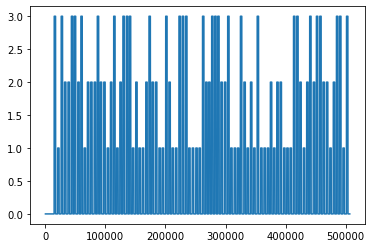

In [14]:
df.paradigm_info.plot()

index              0
paradigm_info    120
dtype: int64


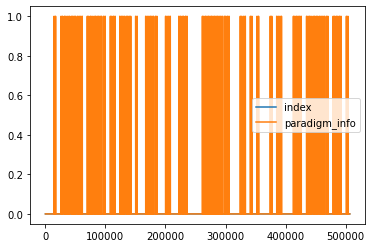

In [23]:
changes = ((df.paradigm_info.iloc[1:].reset_index() - df.paradigm_info.iloc[:-1].reset_index()).abs() > 1).astype("int")
changes.plot()
print(changes.sum())

In [6]:
print(df.data_glove_index.describe())
print(df.paradigm_info.value_counts())

count    507025.000000
mean          0.247886
std           0.301131
min           0.000000
25%           0.075524
50%           0.134398
75%           0.221395
max           1.000000
Name: data_glove_index, dtype: float64
0.0    286801
1.0     73440
2.0     73440
3.0     73344
Name: paradigm_info, dtype: int64


<AxesSubplot:>

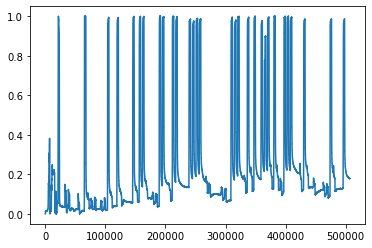

In [7]:
df.data_glove_index.reset_index(drop=True).plot()

<AxesSubplot:>

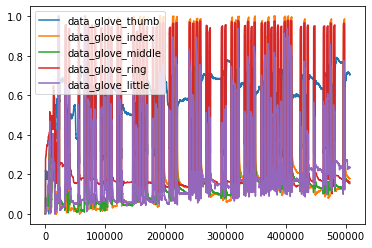

In [8]:
glove_columns = [x for x in df.columns if "glove" in x]
df[glove_columns].plot()

In [26]:
len(df)

507025

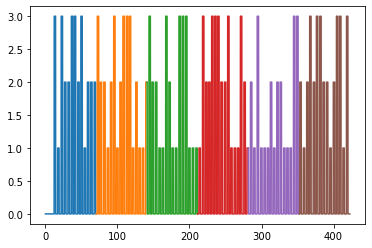

In [24]:
from tqdm.auto import tqdm


n_folds = 8
folds = []
fold_size = len(df) // n_folds
for i in range(0, len(df), fold_size):
    folds.append(df.iloc[i:i+fold_size])
    # folds.append(df.iloc[i//fold_size:].iloc[::fold_size])
for fold in folds:
    plt.plot(fold.time, fold.paradigm_info)

    
def wrap_list(x):
    try:
        len(x)
    except TypeError:
        x = [x]
    return x
    

def percentage_accuracy_score(*args, **kwargs):
    return 100 * sklearn.metrics.accuracy_score(*args, *kwargs)


def cross_fold(models, folds, metrics=percentage_accuracy_score):
    models = wrap_list(models)
    metrics = wrap_list(metrics)
    for model in tqdm(models):
        print(model)
        predicted = []
        true = []
        test_accs = []
        for i, (x_test, y_test) in enumerate(bar := tqdm(folds)):
            x_train, y_train = map(pd.concat, zip(*(folds[:i] + folds[i+1:])))
            model.fit(x_train, y_train)
            y__test = model.predict(x_test)
            predicted.append(y__test)
            true.append(y_test)
            test_acc = percentage_accuracy_score(y_test, y__test)
            test_accs.append(test_acc)
            bar.set_description(f"intermediate accuracy: {test_acc:.4f}, "
                                f"average accuracy: {sum(test_accs) / len(test_accs):.4f}")
        true, predicted = pd.concat(true), np.concatenate(predicted)
        for metric in tqdm(metrics):
            # accuracy decomposes cleanly, but other metrics might not
            print(f"{metric.__name__}: {metric(true, predicted):.4f}")
            
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, predicted)
        plt.show()

        for _ in "haha": print()

# Check glove baseline

  0%|          | 0/4 [00:00<?, ?it/s]

DummyClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 56.5655


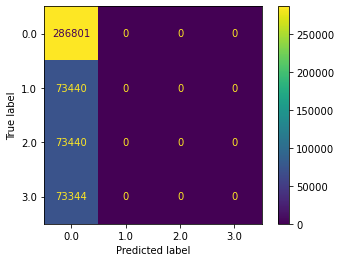





KNeighborsClassifier(n_neighbors=3)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


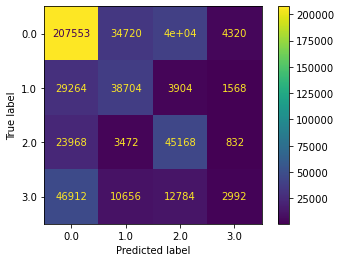





KNeighborsClassifier(n_neighbors=11)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 58.0676


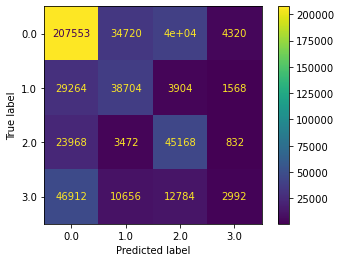





SGDClassifier()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

percentage_accuracy_score: 71.0152


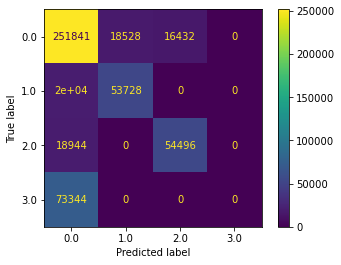

In [25]:
import sklearn
import sklearn.dummy  # not sure why it's not there by default
import sklearn.neighbors


model_templates = [
          sklearn.dummy.DummyClassifier(),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
          sklearn.neighbors.KNeighborsClassifier(n_neighbors=11),
          sklearn.linear_model.SGDClassifier(),
          # sklearn.svm.SVC(kernel="rbf"),
          # sklearn.svm.SVC(kernel="poly"),
          # sklearn.svm.SVC(kernel="gaussian")
]
cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

In [ ]:

cross_fold(model_templates,
           [[fold[glove_columns], fold.paradigm_info] for fold in folds])

# TODO
* Calculate trial info
* Try random Cross-Validation
* Import into MNE
* Use Catboost
* Use real features
* Windowed features
* Band-power
* Filtering
* TDA

In [12]:
1/0

ZeroDivisionError: division by zero